# Creating a Similar Songs Network

*Moses Surumen, Ellen Peng, Kuhuk Goyal*  
*CS 194-31  Final Project*  
*Project Name: Music Networks*

---

## Introduction

The **Million Song Dataset (MSD)** is a freely-available collection of audio features and metadata for a million contemporary popular music tracks. It contains track, song, artist, and album metadata as well as artist similarity and artist tags. The data is stored in HDF5 format, with one file per song.

The dataset was created using the [**Echo Nest**](http://the.echonest.com/) API. More information on the dataset can be found [here](http://labrosa.ee.columbia.edu/millionsong/).


---

In [1]:
# Pandas
import pandas as pd

# Numpy
import numpy as np

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

# Combinations
import itertools

# String Operations
from string import ascii_letters

---
##  Dataset Format

The Million Song Dataset required a lot of pre-processing to get the songs, artists, and relationships in the same files instead of individual json files for each of the 1 million songs.
Python scripts used to do the pre-preprocessing and cleaning are included in the scripts folder

| Column        | Description                            | Format
| :------------ |--------------------------------------: | :-:
| a_similar     | Similar artists                        | array('artistId', 'artistId', ... , 'artistId')
| artist_7did   | Seven digit artist ID                  | 
| artist_id     | Echo Nest artist ID                    | 
| artist_mbid   | Music Brain artist ID                  | 
| artist_name   | Name of the artist                     | string
| dance         | Danceability of the song               | float
| dur           | Duration of the song                   | float
| energy        | Energy of the song                     | float
| song_id       | Echo Nest song ID                      | 
| title         | The title of the song                  |
| track_id      | Echo Nest track ID                     |
| year          | The year the song was released         |






---

## Get Data

In [2]:
df = pd.read_csv('data/similar_songs.csv')

In [11]:
df.head()

,from_track,to_track,sim_measure
0,TRARRUZ128F9307C57,TRGGBUV128F930B5F6,1.000000
1,TRARRUZ128F9307C57,TRKJAYK128F930B613,0.985081
2,TRARRUZ128F9307C57,TRHSFCB128F428D093,0.190086
3,TRARRUZ128F9307C57,TRGJYWK128F428D09A,0.006668
4,TRARRUZ128F9307C57,TRRCYEK128F92F930C,0.006554


## Match Track IDs to Song IDs

This is the most important preprocessing step since Echo Nest Taste Profiles only use song IDs but similar songs measures from the Million Song Dataset only provide track IDs

In [12]:
unique_tracks = pd.read_csv('data/unique_tracks.csv')
unique_tracks.head()
#df['preTestScore'].where(df['postTestScore'] > 50)

,track_id,song_id,artist_name,song_name
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [13]:
# Create copy just in case
df_copy = df

In [17]:
temp_df = df_copy.merge(unique_tracks, left_on='from_track', right_on='track_id', how='outer')
temp_df.head()

,from_track,to_track,sim_measure,track_id,song_id,artist_name,song_name
0,TRARRUZ128F9307C57,TRGGBUV128F930B5F6,1.000000,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight
1,TRARRUZ128F9307C57,TRKJAYK128F930B613,0.985081,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight
2,TRARRUZ128F9307C57,TRHSFCB128F428D093,0.190086,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight
3,TRARRUZ128F9307C57,TRGJYWK128F428D09A,0.006668,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight
4,TRARRUZ128F9307C57,TRRCYEK128F92F930C,0.006554,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight


In [22]:
final_df = temp_df.merge(unique_tracks, left_on='to_track', right_on='track_id', how='outer')

In [23]:
final_df.head()

,from_track,to_track,sim_measure,track_id_x,song_id_x,artist_name_x,song_name_x,track_id_y,song_id_y,artist_name_y,song_name_y
0,TRARRUZ128F9307C57,TRGGBUV128F930B5F6,1.000000,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,TRGGBUV128F930B5F6,SOHXBAV12AB017D7FD,The Baltimore Consort,The Knot
1,TRARRUZ128F9307C57,TRKJAYK128F930B613,0.985081,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,TRKJAYK128F930B613,SOTEUIB12AB01825EE,The Baltimore Consort,Light o' Love
2,TRARRUZ128F9307C57,TRHSFCB128F428D093,0.190086,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,TRHSFCB128F428D093,SOJSHTK12A8C139C90,Mediaeval Baebes,Isabella
3,TRARRUZ128F9307C57,TRGJYWK128F428D09A,0.006668,TRARRUZ128F9307C57,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,TRGJYWK128F428D09A,SOMUCDP12A8C139CB0,Mediaeval Baebes,Now welcom somer
4,TRAPPUL128F9312995,TRGJYWK128F428D09A,0.006819,TRAPPUL128F9312995,SOMLMRZ12AB017D510,The Baltimore Consort,The Beautiful Shepherdess of Arcadia,TRGJYWK128F428D09A,SOMUCDP12A8C139CB0,Mediaeval Baebes,Now welcom somer


In [28]:
final_df = final_df.drop(['track_id_x', 'track_id_y'], axis=1)

In [29]:
# write to new file
final_df.to_csv("data/similar_songs_with_ids.csv", encoding='utf-8', index=False)

In [32]:
# retrieve this file
similar = pd.read_csv('data/similar_songs_with_ids.csv')

/Users/moses/miniconda3/envs/16b/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
similar.head()

,from_track,to_track,sim_measure,song_id_from,artist_name_from,song_name_from,song_id_to,artist_name_to,song_name_to
0,TRARRUZ128F9307C57,TRGGBUV128F930B5F6,1.000000,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,SOHXBAV12AB017D7FD,The Baltimore Consort,The Knot
1,TRARRUZ128F9307C57,TRKJAYK128F930B613,0.985081,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,SOTEUIB12AB01825EE,The Baltimore Consort,Light o' Love
2,TRARRUZ128F9307C57,TRHSFCB128F428D093,0.190086,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,SOJSHTK12A8C139C90,Mediaeval Baebes,Isabella
3,TRARRUZ128F9307C57,TRGJYWK128F428D09A,0.006668,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,SOMUCDP12A8C139CB0,Mediaeval Baebes,Now welcom somer
4,TRAPPUL128F9312995,TRGJYWK128F428D09A,0.006819,SOMLMRZ12AB017D510,The Baltimore Consort,The Beautiful Shepherdess of Arcadia,SOMUCDP12A8C139CB0,Mediaeval Baebes,Now welcom somer


___

## Create Graph

In [3]:
G = nx.Graph()

In [35]:
# Print graph size
print('\nSize of graph, i.e. number of edges:', G.size())


Size of graph, i.e. number of edges: 0


In [8]:
for index, row in df.iterrows():
    if row[2] >= 0.7:
        G.add_edge(row[0], row[1], weight=row[2], length=1.0)
        #G.add_edge(row[3], row[6], weight=row[2], length=1.0)
#         G.node[row[3]]['artist'] = row[4]
#         G.node[row[3]]['name'] = row[5]
#         G.node[row[6]]['artist'] = row[7]
#         G.node[row[6]]['name'] = row[8]

In [37]:
# Print graph size
print('\nSize of graph, i.e. number of edges:', G.size())


Size of graph, i.e. number of edges: 21669


In [38]:
A_WHOLE = nx.adjacency_matrix(G)

In [39]:
print(A_WHOLE[0,0])

0.0


In [40]:
print(A_WHOLE[1,1])

0.0


In [41]:
print(A_WHOLE[0:5,0:5])

  (0, 1)	1.0
  (0, 2)	0.985081
  (1, 0)	1.0
  (2, 0)	0.985081
  (3, 4)	1.0
  (4, 3)	1.0


In [13]:
def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a networkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)

    #Plot adjacency matrix in toned-down black and white
    fig = plt.figure(figsize=(5, 5)) # in inches
    plt.imshow(adjacency_matrix,
                  cmap="Greys",
                  interpolation="none")
    
    # The rest is just if you have sorted nodes by a partition and want to
    # highlight the module boundaries
    assert len(partitions) == len(colors)
    ax = plt.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth="1"))
            current_idx += len(module)

In [10]:
A = nx.to_numpy_matrix(G)

In [15]:
A.shape

(23470, 23470)

In [15]:
print(A[0:5,0:5])

[[0.       0.985081 0.       0.       0.      ]
 [0.985081 0.       0.       0.       0.      ]
 [0.       0.       0.       1.       0.908144]
 [0.       0.       1.       0.       0.      ]
 [0.       0.       0.908144 0.       0.      ]]


In [ ]:
# Compute the correlation matrix
# corr = G.corr()
corr = A

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig('heatmap.pdf')

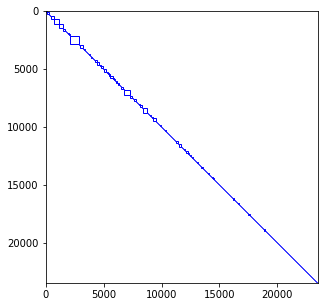

In [23]:
import collections

# Run louvain community finding algorithm
louvain_community_dict = community.best_partition(G)

# Convert community assignmet dict into list of communities
louvain_comms = collections.defaultdict(list)
for node_index, comm_id in louvain_community_dict.items():
    louvain_comms[comm_id].append(node_index)
louvain_comms = louvain_comms.values()

nodes_louvain_ordered = [node for comm in louvain_comms for node in comm]
draw_adjacency_matrix(G, nodes_louvain_ordered, [louvain_comms], ["blue"])

In [ ]:
temp = nx.from_scipy_sparse_matrix(A)
draw_adjacency_matrix(temp)

___

## Compute best partition

In [42]:
# Get best partition
partition = community.best_partition(G)
print('Modularity: ', community.modularity(partition, G))

Modularity:  0.9910023126693569


## Draw Graph to Gephi

In [43]:
nx.write_gexf(G, "network.gexf")

(array([2.3225e+04, 4.9000e+01, 3.5000e+01, 2.2000e+01, 2.2000e+01,
        9.0000e+00, 7.0000e+00, 3.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([  1.,  22.,  43.,  64.,  85., 106., 127., 148., 169., 190., 211.]),
 <a list of 10 Patch objects>)

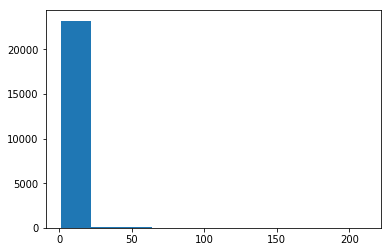

In [51]:
# power law histogram
plt.hist(list(dict(nx.degree(G)).values()))

In [56]:
similar = similar[similar.sim_measure > 0.6]

In [57]:
# Compute the mean route length per airline.
deg_vals = similar.groupby("sim_measure")
deg_vals.head()

,from_track,to_track,sim_measure,song_id_from,artist_name_from,song_name_from,song_id_to,artist_name_to,song_name_to
0,TRARRUZ128F9307C57,TRGGBUV128F930B5F6,1.000000,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,SOHXBAV12AB017D7FD,The Baltimore Consort,The Knot
1,TRARRUZ128F9307C57,TRKJAYK128F930B613,0.985081,SOEYIHF12AB017B5F4,The Baltimore Consort,Howells Delight,SOTEUIB12AB01825EE,The Baltimore Consort,Light o' Love
21,TRARRER128F9328521,TREFJNN128F9328534,1.000000,SOVVDCO12AB0187AF7,Brand X,Liquid Time (composition by John Goodsall),SOKQAET12AB017E52B,Brand X,Mental Floss (composition by John Goodsall)
22,TRARRER128F9328521,TRGSMOL128F932851A,0.908144,SOVVDCO12AB0187AF7,Brand X,Liquid Time (composition by John Goodsall),SOSMZTP12AB0187AE4,Brand X,Xanax Taxi (composition by John Goodsall)
280,TRARREF128F422FD96,TRKNQYA128F42AC2F7,1.000000,SOZQSGL12AF72A9145,Dead Kennedys,Halloween,SOWURMJ12A8C13EAFD,Dead Kennedys,Forest Fire
281,TRARREF128F422FD96,TRPZDNK128F42AC2F6,0.975826,SOZQSGL12AF72A9145,Dead Kennedys,Halloween,SOAMZVL12A8C13EAF5,Dead Kennedys,Buzzbomb
353,TRAULZG128F425E06C,TRBVASR128F425E069,1.000000,SOMTRKO12A8C134D55,Black Flag,Police Story,SOMCNIO12A8C134D4C,Black Flag,Depression
358,TRAULZG128F425E06C,TRQJVBD128F425E071,1.000000,SOMTRKO12A8C134D55,Black Flag,Police Story,SONLJTD12AF72A68A1,Black Flag,Depression
430,TRAYYZG12903CE7914,TRMGBNU128F4278587,0.889009,SODSOBX12AC4686B4D,U.K. Subs,Warhead (Live in Croatia_ 1993),SORMJWQ12A8C13BAA3,Exploited,Punk's Not Dead (album)
692,TRALPXC128E07819A8,TRGXZGQ128F1465892,0.987275,SOESQNH12A58A79AC3,Sex Pistols,Pretty Vacant,SODZSZM12A58A7AEA1,Sex Pistols,Problems


___

## Filter communities

Choose partitions with at least 25 songs

In [46]:
# Keep only communities with a minimum of songs
centers = {}
communities = {}
G_main_com = G.copy()
min_songs = 25
# max_songs = 50
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    if len(list_nodes) < min_songs:
        G_main_com.remove_nodes_from(list_nodes)
    else:
        # Get center
        H = G_main_com.subgraph(list_nodes)
        d_c = nx.degree_centrality(H)
        center = max(d_c, key=d_c.get)
        centers[center] = com
        communities[com] = center

In [48]:
nodes_main_com = {k: v for k, v in partition.items() if v in communities}
ind = community.induced_graph(nodes_main_com, G_main_com)

## Display graph

/Users/moses/miniconda3/envs/16b/lib/python3.6/site-packages/networkx/drawing/layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


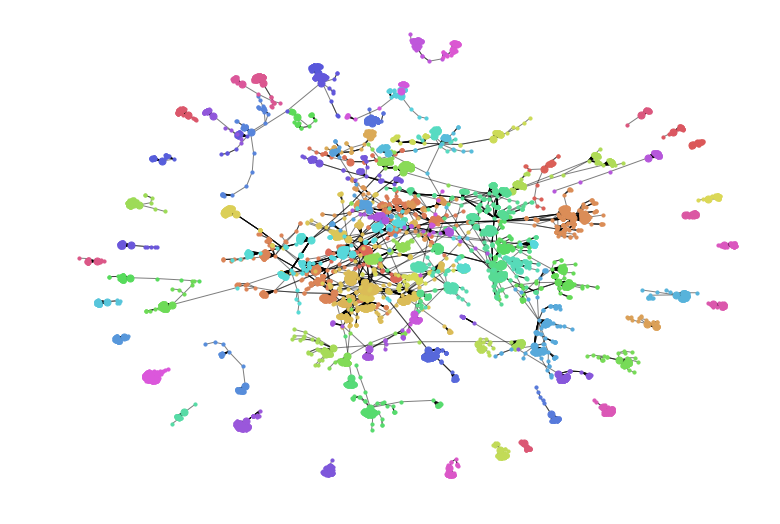

In [43]:
plt.figure(figsize=(13, 9))
node_size = 10
count = 0
pos = nx.spring_layout(G_main_com)
colors = dict(zip(communities.keys(), sns.color_palette('hls', len(communities.keys()))))

for com in communities.keys():
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com and nodes not in communities.values()]
    nx.draw_networkx_nodes(G_main_com, pos, list_nodes, node_size = node_size, node_color = colors[com])
    nx.draw_networkx_nodes(G_main_com, pos, list([communities[com]]), node_size = node_size*5, node_color = colors[com])
nx.draw_networkx_edges(G_main_com, pos, alpha=0.5)
labels = {k: str(v) + ': ' + k for k,v in centers.items()}
plt.axis('off')
plt.savefig("communities_viz.png", dpi=1000)
plt.show()

In [32]:
nx.write_gexf(G_main_com, "communities.gexf")

____

## Export Graph Variables to Other Notebooks

In [50]:
%store G
%store G_main_com
%store partition
%store communities

Stored 'G' (Graph)
Stored 'G_main_com' (Graph)
Stored 'partition' (dict)
Stored 'communities' (dict)
